In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import time
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [2]:
%run ../stochastic_batch_lstm_optimizer.py

In [3]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, loss_type='sum', lambd=1e-5, **kwargs):
        n_steps = T.iscalar()
        
        l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
        self.l_optim = LSTMOptimizerLayer(l_input, n_steps=n_steps, function=func, **kwargs)
        
        self.params_init = L.layers.get_all_param_values(self.l_optim)

        theta_history, loss_history, scan_updates = L.layers.get_output(self.l_optim)

        self.loss_type = loss_type
        if loss_type == 'sum':
            loss = loss_history.sum()
        elif loss_type == 'prod':
            loss = T.log(loss_history).sum()
        elif loss_type == 'weighted_prod':
            loss = (T.log(loss_history) * 0.9**T.arange(loss_history.shape[0])[::-1]).sum()
                
        loss += lambd * L.regularization.regularize_network_params(self.l_optim, L.regularization.l2)
                
        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.l_optim)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        updates.update(scan_updates)
        
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True, updates=scan_updates)
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], updates=updates, allow_input_downcast=True)
        
    def reset_network(self):
        L.layers.set_all_param_values(self.l_optim, self.params_init)
        
    def train(self, sample_function, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        optimizer_loss = []
        optimizer_moving_loss = []
        moving_loss = None
        
        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                theta, params = sample_function()
 
                theta_history, loss_history = self.train_fn(theta, n_iter, *params)
                if self.loss_type == 'sum':
                    loss = np.sum(loss_history)
                else:
                    loss = np.sum(np.log(loss_history))
                training_loss_history.append(loss_history)
            
                optimizer_loss.append(loss)
                if moving_loss is None:
                    moving_loss = loss
                else:
                    moving_loss = 0.9 * moving_loss + 0.1 * loss
                optimizer_moving_loss.append(moving_loss)

            display.clear_output(wait=True)
            plt.figure(figsize=(15, 12))
            
            plt.subplot(2, 1, 2)
            plt.semilogy(np.median(training_loss_history, axis=0))
            
            plt.subplot(2, 1, 1)
            if self.loss_type == 'sum':
                plt.semilogy(optimizer_loss, 'b', label='loss')
                plt.semilogy(optimizer_moving_loss, 'r', label='moving loss')
            else:
                plt.plot(optimizer_loss, 'b', label='loss')
                plt.plot(optimizer_moving_loss, 'r', label='moving loss')
            
            plt.show()
            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)

In [4]:
class QuadraticFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.matrix('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((T.dot(self.W, self.theta) - self.b)**2).sum() / self.W.shape[0]
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [5]:
class DiagFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.vector('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((self.W * self.theta - self.b)**2).sum() / self.W.shape[0]
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [6]:
W = T.matrix()
b = T.vector()
    
w = T.vector()
    
#func = lambda theta: QuadraticFunction(theta, W, b).func
func = lambda theta: DiagFunction(theta, w, b).func

In [7]:
input_var = T.vector()

In [8]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

#sgd_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)
sgd_fn = theano.function([input_var, n_steps, w, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [9]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

# momentum_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
#         momentum_mu: np.cast['float32'](0.9),
#     })

momentum_fn = theano.function([input_var, n_steps, w, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

In [10]:
lstm_optimizers = {}

options = {
    'num_units': 20,
    'gradient_steps': 20,
    'n_layers': 2,
    'preprocess_input': False,
    
    'p_drop_coord': 0.0,
    'p_drop_delta': 0.0,
    'fix_drop_delta_over_time': True,
}

# for n_gac in [0, 5]:
#     for loss_type in ['sum', 'prod']:
for n_gac in [0]:
    for loss_type in ['sum']:
        for p_drop_coord in [0.0, 0.5]:
            for p_drop_delta in [0.0, 0.5]:
                options['n_gac'] = n_gac
                options['loss_type'] = loss_type

                key = "n_gac={}; loss_type={}; p_drop_coord={}, p_drop_delta={}".format(n_gac, loss_type, p_drop_coord, p_drop_delta)
                lstm_optimizers[key] = LSTMOptimizer(input_var, func, [w, b], **options)

In [11]:
def sample_params(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.random.randn(ndim, ndim))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point(ndim):
    theta = np.cast['float32'](np.random.randn(ndim))
    return theta

def sample_point_and_params(ndim=None):
    W, b = sample_params(ndim)
    theta = sample_point(len(b))
    
    return theta, (W, b)

def sample_params_diag(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.diag(np.random.randn(ndim)))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point_and_params_diag(ndim=10):
    W, b = sample_params_diag(ndim)
    theta = sample_point(len(b))
    
    return theta, (np.diag(W), b)

# #data = [sample_point_and_params(ndim=ndim+1) for _ in range(10) for ndim in range(20)]
# data = [sample_point_and_params(ndim=ndim+1) for _ in range(200) for ndim in range(10)]
# np.random.shuffle(data)
# data_index = 0

# def sample_from_data():
#     global data_index
#     theta, (W_, b_) = data[data_index]
#     data_index = (data_index + 1) % len(data)
#     return theta, (W_, b_)

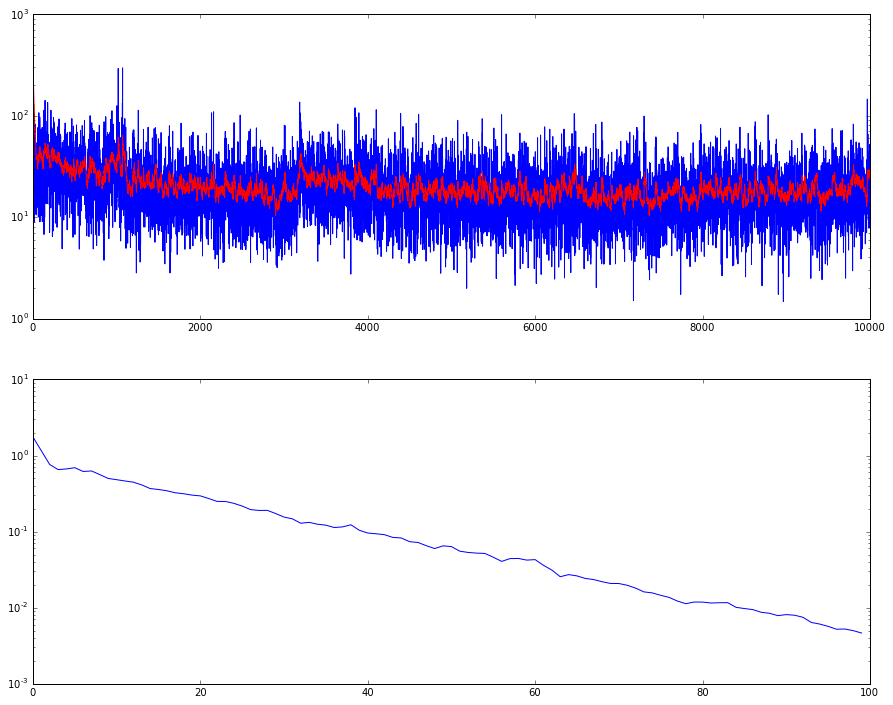

Epoch number 49
Time on epoch 49: 17.315397262573242
Loss on 49: 13.617114369757473; 0.004652130184695125


In [12]:
training_options = {
    'n_iter': 100,
    'n_epochs': 50,
    'batch_size': 200,
    'decay_rate': 0.96,
}

for key, opt in lstm_optimizers.items():
    opt.reset_network()
    opt.lr.set_value(0.01)
    opt.train(sample_point_and_params_diag, **training_options)

In [13]:
non_lstm_optimizers = {
    'momentum': momentum_fn
}

In [14]:
def test_optimizers(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
#         plt.semilogy(np.median(loss_history, axis=0), label='lstm; {}'.format(key))
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
#     lrates = np.logspace(0, 19, num=20, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
#         plt.semilogy(best_history, label="{name}; lr={best_lrate}".format(**locals()), linestyle='--')
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history

#     plt.legend()
#     plt.show()
    return histories

In [15]:
testing_options = {
    'n_iter': 200,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params_diag
}

histories = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.5
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.5
Testing momentum


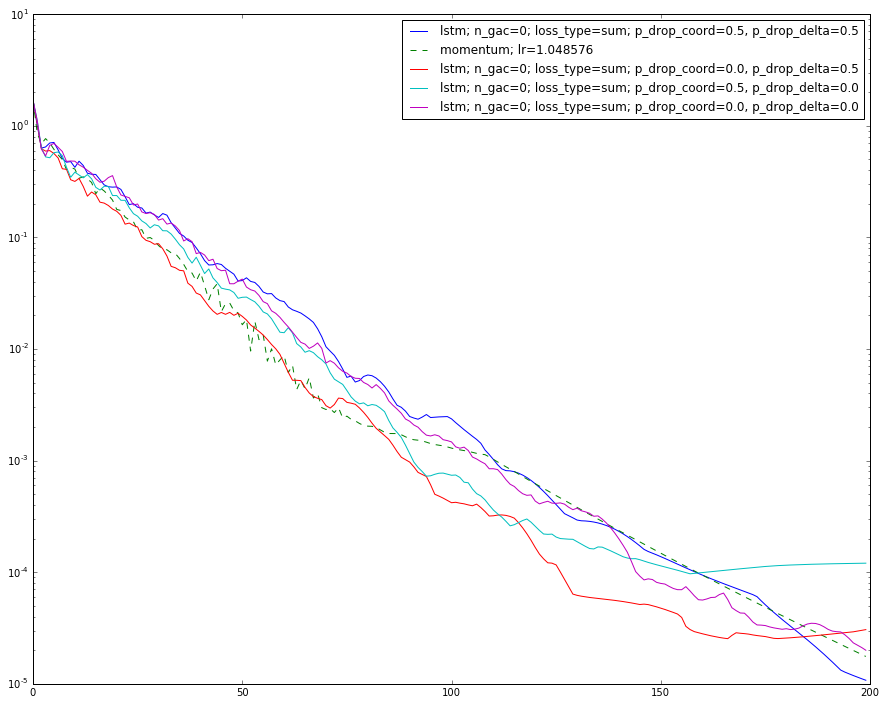

In [16]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = ('--' if name.find('lstm') == -1 else '-')
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [258]:
theta, (W_, b_) = sample_point_and_params_diag(ndim=2)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [W_, b_], 300)
    #history, losses = opt.loss_det_fn(theta, 300, W_, b_)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)

sample_runs['momentum'] = momentum_fn(theta, 300, W_, b_, 0.262144)
    
# for name, opt in non_lstm_optimizers.items():
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#             history, losses = opt(theta, 300, W_, b_, lrate)
#             history = [theta] + history

#             sample_runs["{}; lr={}".format(name, lrate)] = (history, losses)

[ 0.00429556 -0.66340166]


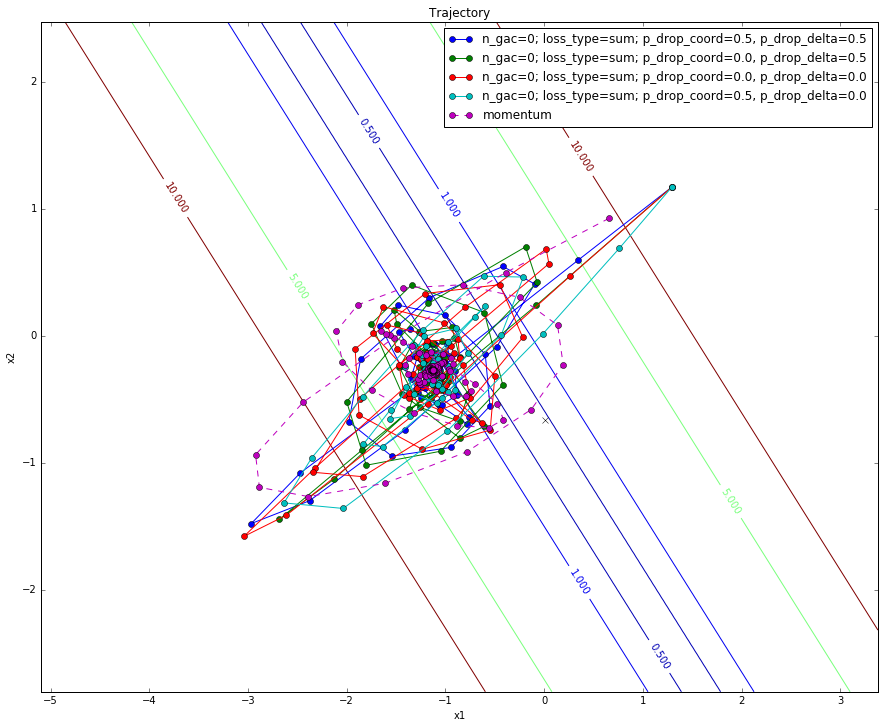

In [259]:
#theta_opt = np.linalg.pinv(W_).dot(b_)

min_x = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
max_x = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
min_y = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])
max_y = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
# x = np.arange(min_x, max_x, delta_x)
# y = np.arange(min_y, max_y, delta_y)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
        Z[i][j] = z

#Z = ((W.dot(X) - b_)**2).sum()

plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('x1')
plt.ylabel('x2')

for name in lstm_optimizers:
    history, _ = sample_runs[name]
    plt.plot(history.T[0], history.T[1], marker='o', label=name)

history, _ = sample_runs['momentum']
plt.plot(np.array(history).T[0], np.array(history).T[1], label='momentum', marker='o', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#         #if 1e-4 < lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             history, _ = sample_runs[key]
#             plt.plot(np.array(history).T[0], np.array(history).T[1], label=key, marker='o', linestyle='--')

print(theta_opt)
plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')            
plt.legend();

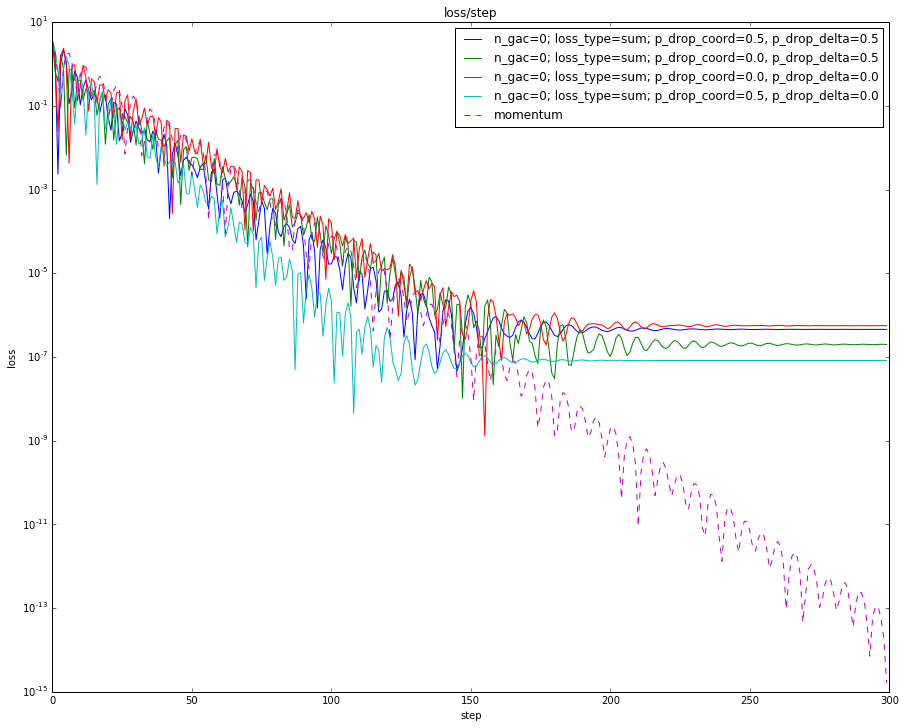

In [260]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in lstm_optimizers:
    _, losses = sample_runs[name]
    plt.semilogy(losses, label=name)

_, losses = sample_runs['momentum']    
plt.semilogy(losses, label='momentum', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008912:
#         #if lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             _, losses = sample_runs[key]
#             plt.semilogy(losses, label=key, linestyle='--')
plt.legend();

In [25]:
import itertools

generalization_loss_lstm = {name: [] for name in lstm_optimizers}

for n_c in itertools.chain(range(2, 50), range(900, 950)):
    print(n_c)
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for _ in range(10):
            theta, (W_, b_) = sample_point_and_params_diag(ndim=n_c)    
            #loss = 1. / n_c * opt.optimize(theta, [W_, b_], 100)[1][-1]
            loss = opt.optimize(theta, [W_, b_], 100)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm[name].append(np.mean(losses))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949


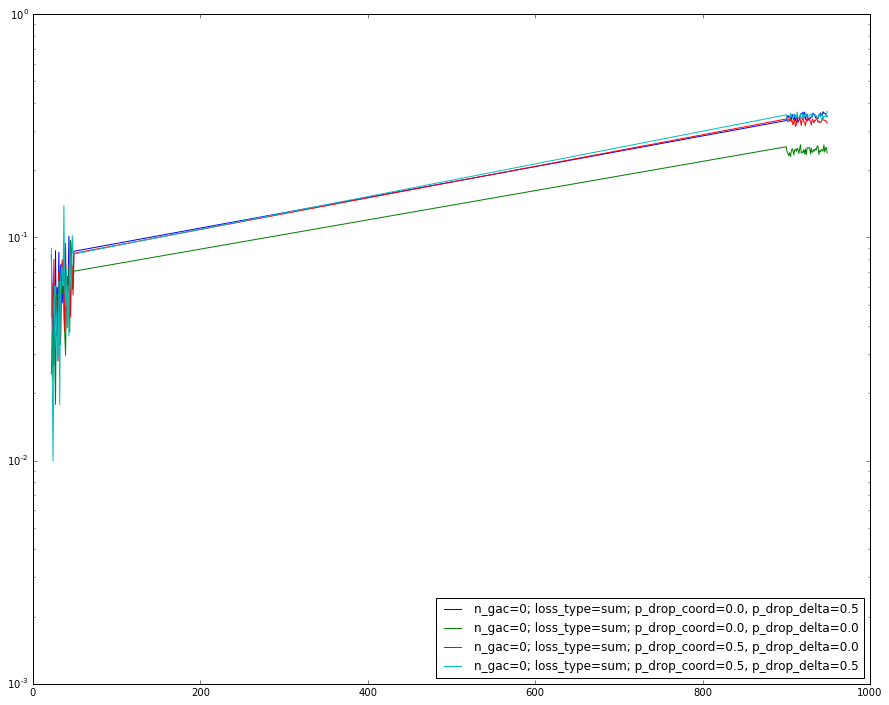

In [26]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm.items():
    plt.semilogy(list(range(22, 50)) + list(range(900, 950)), losses[20:], label=name)
plt.legend(loc=4);

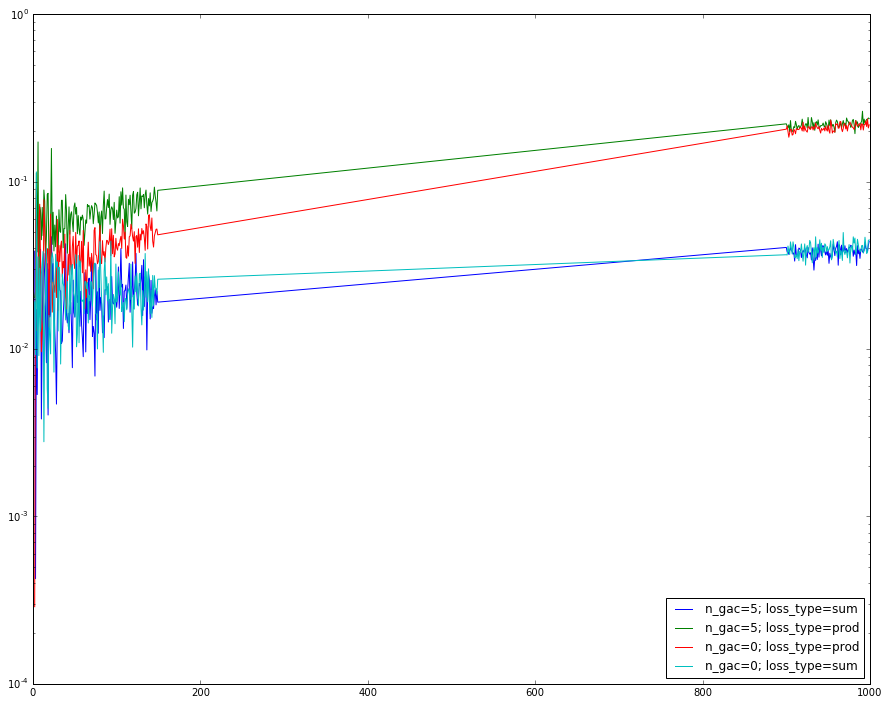

In [31]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm.items():
    plt.semilogy(list(range(2, 150)) + list(range(900, 1000)), losses, label=name)
plt.legend(loc=4);

In [32]:
for name, opt in lstm_optimizers.items():
    np.savez('final_quadratic_optimizer_({}).npz'.format(name), L.layers.get_all_param_values(opt.l_optim))

In [53]:
import theano.sandbox.cuda.basic_ops as sbcuda
print(sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]/1024./1024/1024)

4.048732757568359


In [40]:
for name, opt in lstm_optimizers.items():
    with np.load('final_quadratic_optimizer_({}).npz'.format(name)) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    L.layers.set_all_param_values(opt.l_optim, param_values[0])

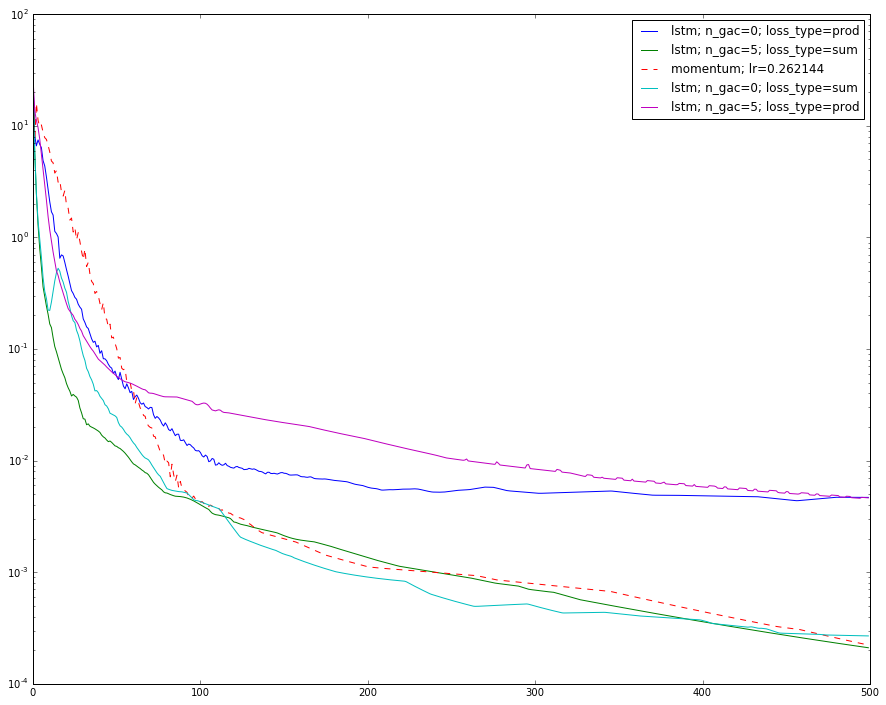

In [ ]:
plt.figure(figsize=(15, 12))
for name, hist in histories_.items():
    linestyle = ('--' if name.find('lstm') == -1 else '-')
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

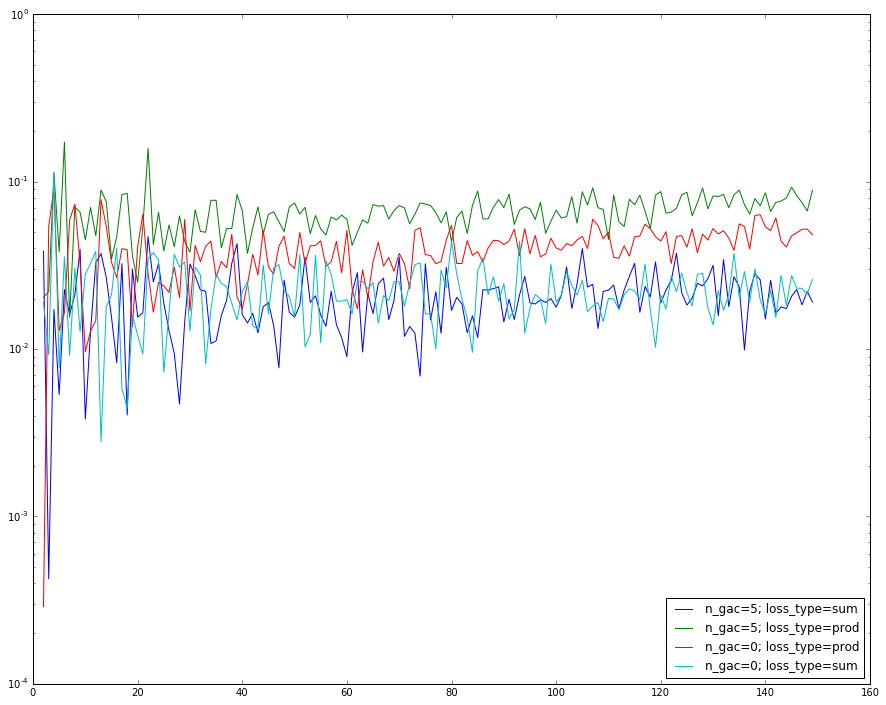

In [55]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm.items():
    plt.semilogy(list(range(2, 150)), losses[:148], label=name)
plt.legend(loc=4);

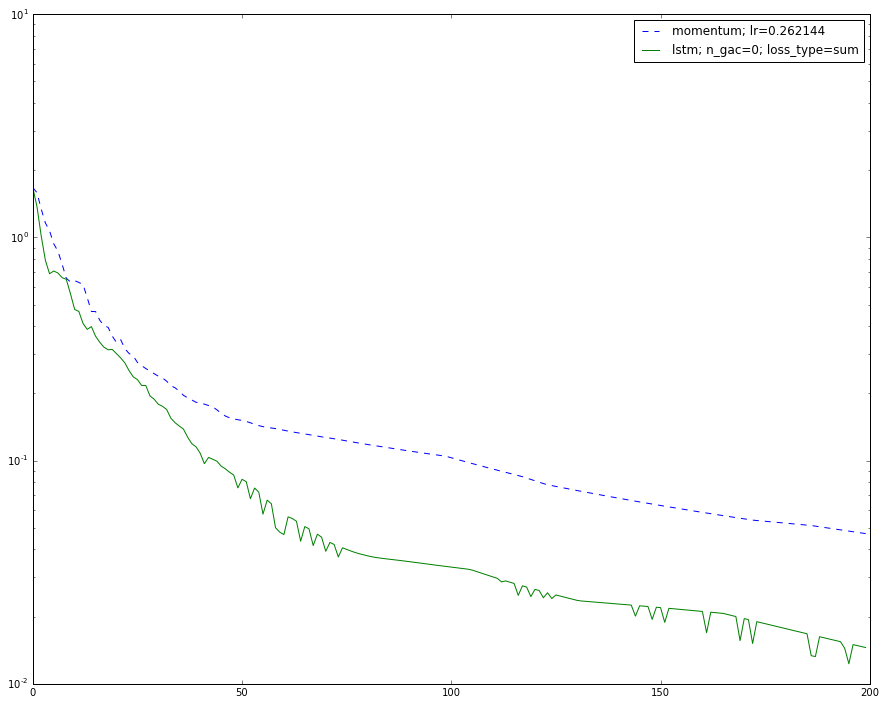

In [85]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = ('--' if name.find('lstm') == -1 else '-')
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [266]:
theta, (W_, b_) = sample_point_and_params_diag(ndim=100)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [W_, b_], 300)
    #history, losses = opt.loss_det_fn(theta, 300, W_, b_)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)

sample_runs['momentum'] = momentum_fn(theta, 300, W_, b_, 1.048576)

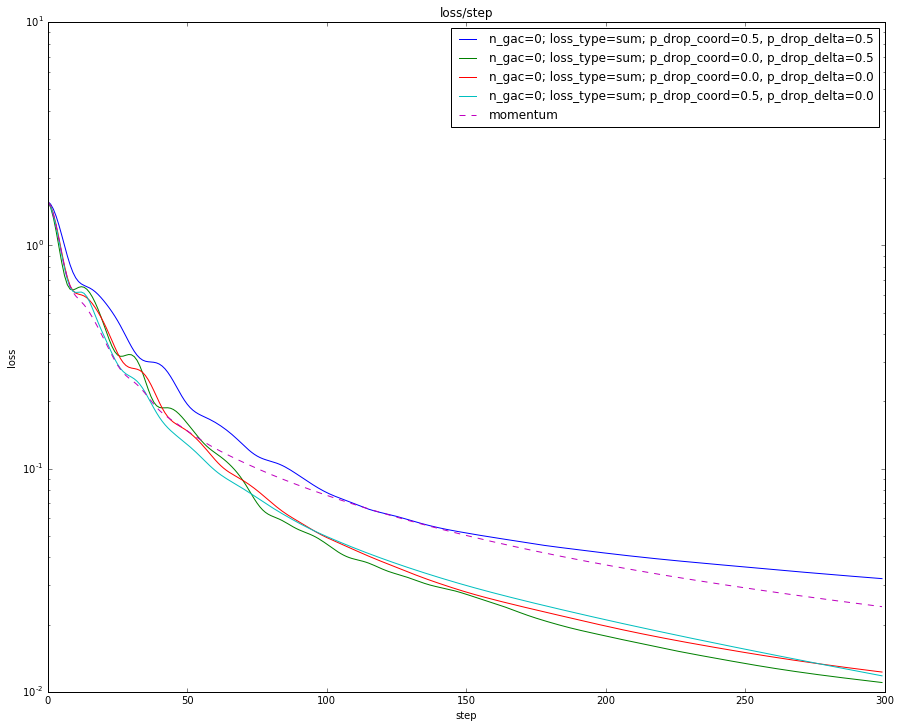

In [267]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in lstm_optimizers:
    _, losses = sample_runs[name]
    plt.semilogy(losses, label=name)

_, losses = sample_runs['momentum']    
plt.semilogy(losses, label='momentum', linestyle='--')
plt.legend();

In [268]:
testing_options = {
    'n_iter': 200,
    'n_functions': 50,
    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
#     'sampler': sample_point_and_params_diag
}

histories = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.5
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.5
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.0
Testing momentum


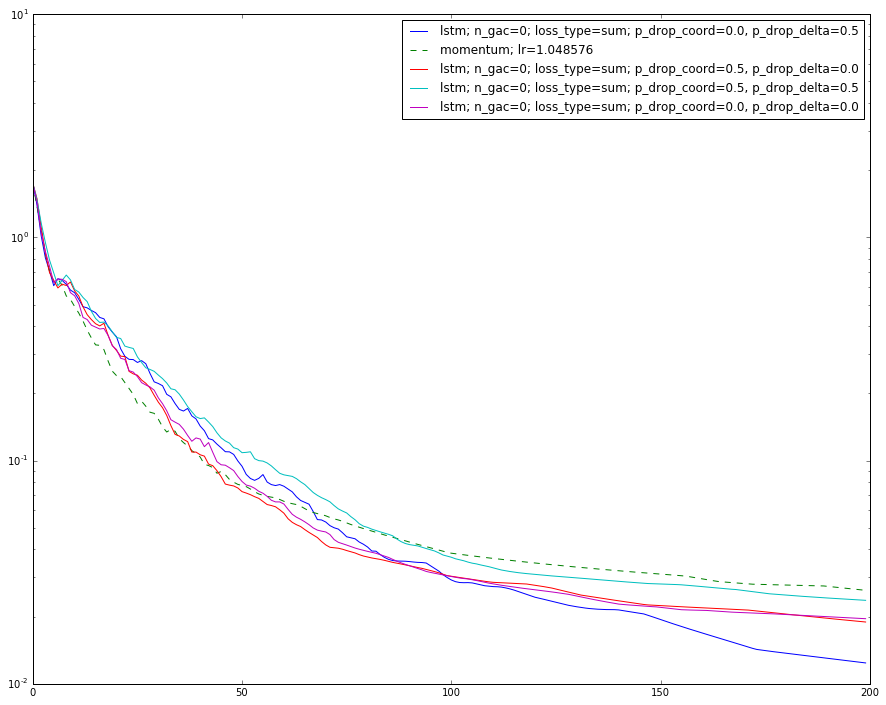

In [269]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = ('--' if name.find('lstm') == -1 else '-')
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [270]:
testing_options = {
    'n_iter': 200,
    'n_functions': 50,
#     'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': lambda: sample_point_and_params_diag(10)
}

histories = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.5
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.5
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.0
Testing momentum


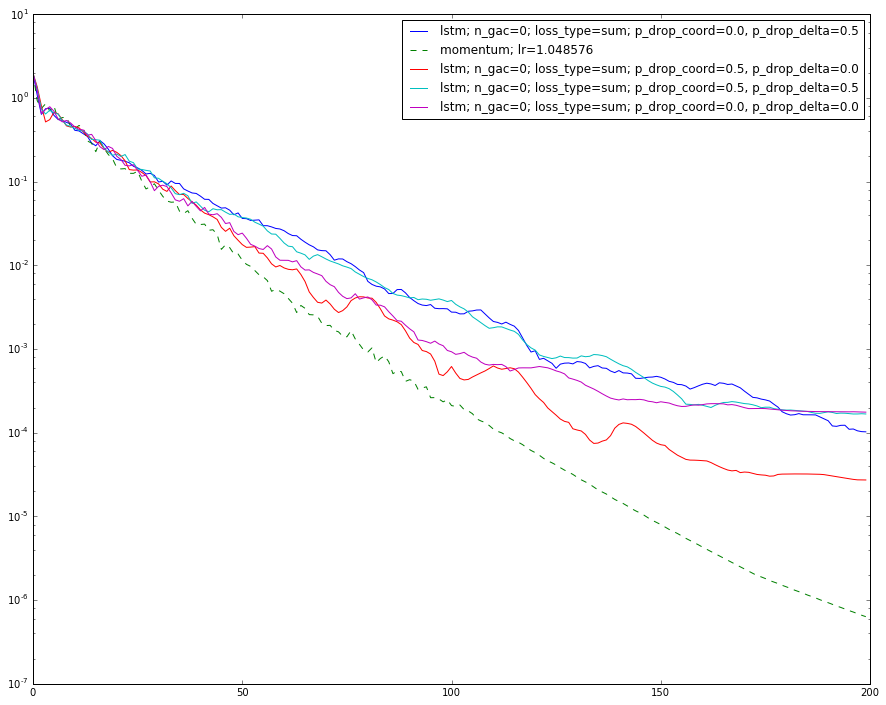

In [271]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = ('--' if name.find('lstm') == -1 else '-')
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [17]:
testing_options = {
    'n_iter': 200,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params_diag
}

histories = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.5
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.5
Testing momentum


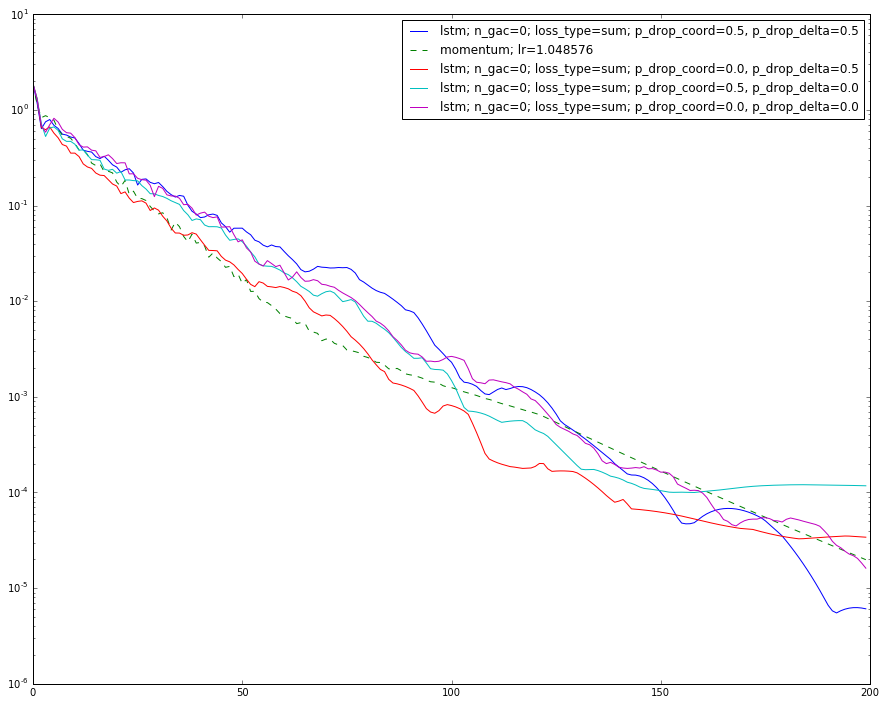

In [18]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = ('--' if name.find('lstm') == -1 else '-')
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [19]:
def add_det_fn(opt, func_params):
    theta_history, loss_history, scan_updates = L.layers.get_output(opt.l_optim, deterministic=True)
    opt.loss_det_fn = theano.function([input_var, opt.l_optim.n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True, updates=scan_updates)

In [21]:
for name, opt in lstm_optimizers.items():
    add_det_fn(opt, [w, b])

In [22]:
def test_optimizers_det(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
#             loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
            loss_history.append(opt.loss_det_fn(theta, testing_options['n_iter'], W_, b_)[1])
#         plt.semilogy(np.median(loss_history, axis=0), label='lstm; {}'.format(key))
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
#     lrates = np.logspace(0, 19, num=20, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
#         plt.semilogy(best_history, label="{name}; lr={best_lrate}".format(**locals()), linestyle='--')
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history

#     plt.legend()
#     plt.show()
    return histories

In [23]:
testing_options = {
    'n_iter': 200,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params_diag
}

histories = test_optimizers_det(**testing_options)

Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.5
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.0, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.0
Testing lstm; n_gac=0; loss_type=sum; p_drop_coord=0.5, p_drop_delta=0.5
Testing momentum


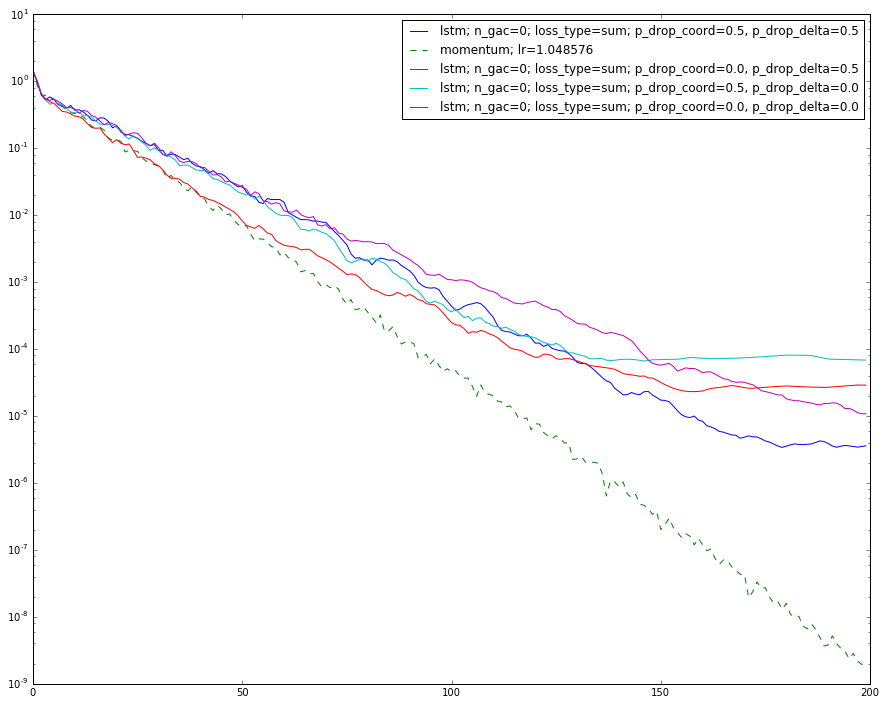

In [24]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = ('--' if name.find('lstm') == -1 else '-')
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();